In [ ]:
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
!pip install datasets transformers

  Using cached pyarrow-11.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-11.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 11.0.0 which is incompatible.
datasets 3.1.0 requires pyarrow>=15.0.0, but you have pyarrow 11.0.0 which is incompatible.
pylibcudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 11.0.0 which is incompatible.


  Using cached pyarrow-18.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-18.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.1 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.
pylibcudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.


ValueError: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 88 from C header, got 72 from PyObject

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.head())

                                          Generation         label
0  ' of paying more than ps1bn in fines to insure...  gpt2_pytorch
1  'dead sea shrinking by 1 meter every year the ...    gpt2_small
2  a blow to the head makes an instant hero in in...    fair_wmt19
3  ' ethereum release was released on april 18th,...  gpt2_pytorch
4  government sets up co-ordination panel to spee...    fair_wmt19


In [ ]:
target_map = {}
test_target = {}
i = 0
for source in train_df['label'].unique():
  target_map[source] = i
  test_target[source] = i
  i+=1

In [ ]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict

train_df['target'] = train_df['label'].map(target_map)
test_df['target'] = test_df['label'].map(test_target)

train_df = train_df[['Generation','target']]
train_df.columns = ['text','label']


test_df = test_df[['Generation','target']]
test_df.columns = ['text','label']
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)

<ipython-input-34-fbf23aa71f80>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=train_df, palette='Set2')


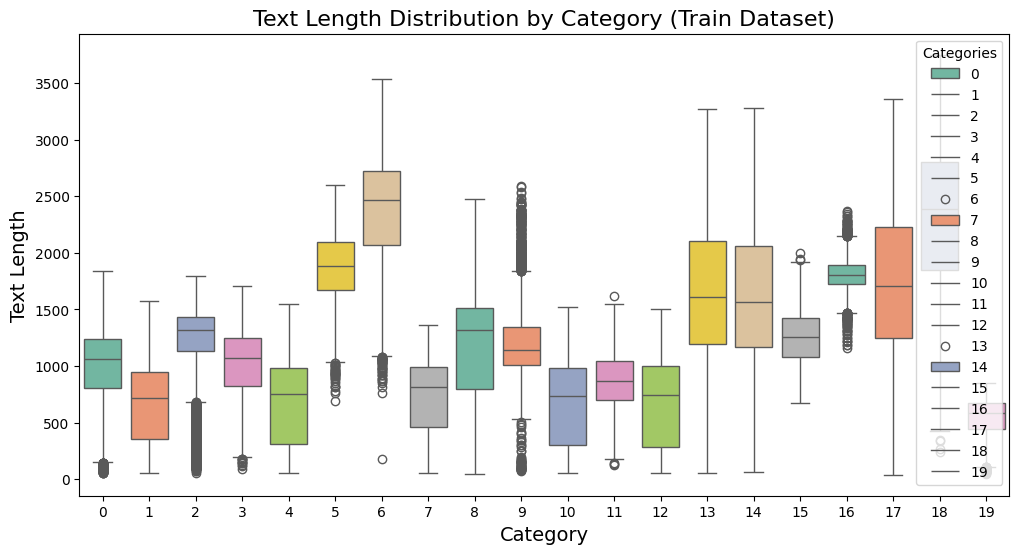

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


train_df = train_dataset.to_pandas()

train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(12, 6))

sns.boxplot(x='label', y='text_length', data=train_df, palette='Set2')


plt.title('Text Length Distribution by Category (Train Dataset)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Text Length', fontsize=14)

plt.legend(title='Categories', labels=[str(label) for label in train_df['label'].unique()], loc='upper right', bbox_to_anchor=(1, 1))


plt.show()


In [ ]:
import re
import statistics

def median_text_length(texts):
    word_counts = [len(text.split()) for text in texts]
    return statistics.median(word_counts)

median_length = median_text_length(train_dataset['text'])
print(f"Median length of text samples: {median_length:.2f} words")

max_length = 169

def clean_and_truncate_text(text, max_length):
    words = re.findall(r'\b\w+\b', text.lower())
    truncated_text = ' '.join(words[:max_length])
    return truncated_text

train_dataset_new = train_dataset.map(lambda x: {'text': clean_and_truncate_text(x['text'], max_length)})

train_dataset_sample = train_dataset_new.select(range(5))
for text in train_dataset_sample['text']:
    print(len(text.split()))

Median length of text samples: 169.00 words


Map:   0%|          | 0/112204 [00:00<?, ? examples/s]

169
169
169
64
169


In [ ]:
dataset = DatasetDict({
    'train':train_dataset_new,
    'test':test_dataset
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 112204
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 37357
    })
})

In [ ]:
from transformers import AutoTokenizer
checkpoint = 'openai-community/gpt2' #base model


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_fn(batch):
  # Use the pre-defined tokenizer for consistency
  encoded_data = tokenizer(batch['text'], truncation=True, padding="max_length",max_length = 169)
  return encoded_data

tokenized_dataset = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/112204 [00:00<?, ? examples/s]

Map:   0%|          | 0/37357 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 20).to('cuda')

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.pad_token_id = tokenizer.eos_token_id
!pip install torchinfo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                             Param #
GPT2ForSequenceClassification                      --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              38,597,376
│    └─Embedding: 2-2                              786,432
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         7,087,872
│    │    └─GPT2Block: 3-2                         7,087,872
│    │    └─GPT2Block: 3-3                         7,087,872
│    │    └─GPT2Block: 3-4                         7,087,872
│    │    └─GPT2Block: 3-5                         7,087,872
│    │    └─GPT2Block: 3-6                         7,087,872
│    │    └─GPT2Block: 3-7                         7,087,872
│    │    └─GPT2Block: 3-8                         7,087,872
│    │    └─GPT2Block: 3-9                         7,087,872
│    │    └─GPT2Block: 3-10                        7,08

In [ ]:
!pip install accelerate==0.26.0

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

                                  )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [ ]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics
                  )

/tmp/ipykernel_719/495014725.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model,


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.589000,0.931241,0.664320,0.664320
2,0.459500,0.818648,0.708756,0.708756
3,0.407500,0.934246,0.722114,0.722114


TrainOutput(global_step=42078, training_loss=0.6189477765388467, metrics={'train_runtime': 37244.4331, 'train_samples_per_second': 9.038, 'train_steps_per_second': 1.13, 'total_flos': 1.7593983364497408e+17, 'train_loss': 0.6189477765388467, 'epoch': 3.0})